# Modelling for Predicting Employee Attrition 
*By Bhavya Bhargava*<br>

### **Why Build a Classification Model on HR Attrition Data?**  

After preparing HR attrition data, visualizing trends, and conducting statistical analysis, **building a classification model** allows for predictive insights and proactive decision-making.  

📊 **Predicts Employee Attrition** – A classification model helps identify employees who are at high risk of leaving based on historical patterns.  

🔍 **Automates Decision-Making** – Machine learning models enable HR teams to assess attrition risk automatically rather than relying solely on manual analysis.  

📈 **Identifies Key Retention Factors** – Feature importance analysis highlights the most influential factors driving attrition, such as job satisfaction, salary hikes, or work-life balance.  

⚡ **Enables Targeted Retention Strategies** – By categorizing employees into "Likely to Stay" and "Likely to Leave," HR teams can take proactive measures to improve engagement and reduce turnover.  

🚀 **Optimizes Workforce Planning** – Predictive modeling supports long-term HR planning by forecasting potential attrition rates and workforce stability.  

By implementing a classification model, organizations **transform HR attrition analysis from reactive insights to proactive workforce management**, ensuring data-driven retention strategies.
<br>
<br>
_Now let's start creating a comprehensive model for predicting employee attrition using random forests_
<br>
<br>
To begin with, let's initialize the environment for our modelling by importing required libraries and loading our dataset.

In [22]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

# Setting the style for visualizations
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
%matplotlib inline

# Loading the dataset
employee_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition_Processed.csv')

# For ignoring unncecessary warnings that may arise
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

Let's start off with first taking a look at our data.

In [23]:
# Displaying first few rows and basic information
print("Dataset Shape:", employee_data.shape)
display(employee_data.head())
employee_data.info()

Dataset Shape: (1470, 51)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,EnvironmentSatisfaction_Encoded,Gender_Encoded,JobInvolvement_Encoded,JobRole_Encoded,JobSatisfaction_Encoded,MaritalStatus_Encoded,OverTime_Encoded,PerformanceRating_Encoded,RelationshipSatisfaction_Encoded,WorkLifeBalance_Encoded
0,41,1,Travel_Rarely,1102,Sales,1,College,Life Sciences,Medium,Female,...,2,0,0,7,3,2,1,0,1,0
1,49,0,Travel_Frequently,279,Research & Development,8,Below College,Life Sciences,High,Male,...,0,1,2,6,2,1,0,1,3,2
2,37,1,Travel_Rarely,1373,Research & Development,2,College,Other,Very High,Male,...,3,1,2,2,0,2,1,0,2,2
3,33,0,Travel_Frequently,1392,Research & Development,3,Master,Life Sciences,Very High,Female,...,3,0,0,6,0,1,1,0,0,2
4,27,0,Travel_Rarely,591,Research & Development,2,Below College,Medical,Low,Male,...,1,1,0,2,2,1,0,0,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               1470 non-null   int64  
 1   Attrition                         1470 non-null   int64  
 2   BusinessTravel                    1470 non-null   object 
 3   DailyRate                         1470 non-null   int64  
 4   Department                        1470 non-null   object 
 5   DistanceFromHome                  1470 non-null   int64  
 6   Education                         1470 non-null   object 
 7   EducationField                    1470 non-null   object 
 8   EnvironmentSatisfaction           1470 non-null   object 
 9   Gender                            1470 non-null   object 
 10  HourlyRate                        1470 non-null   int64  
 11  JobInvolvement                    1470 non-null   object 
 12  JobLev

As the shape and feature data is consistent from the preparation stage we can move forward with the various statistical analysis tests.

We can start with...

<i><u>Specific data preprocessing</u></i> for taking care of categorical variables and preparing data for modelling.

In [24]:
# Converting categorical target variable to numerical
label = LabelEncoder()
employee_data["Attrition"] = label.fit_transform(employee_data.Attrition)

# Display distribution of target variable
print("\nAttrition Distribution:")
print(employee_data["Attrition"].value_counts(normalize=True))


Attrition Distribution:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64


With an idea of distribution of the Attrition feature we can move forward with Feature Engineering.

In <b><u>Feature Engineering</u></b>:
1. We convert categorical variables to numerical format because machine learning models can't process text data.
2. We select features that have a meaningful correlation with attrition helping us reduce noise and improve model performance.
3. Features with correlation > 0.02 are kept for modeling.

In [25]:
# Transforming categorical features into dummy variables
categorical_columns = [column for column in employee_data.drop('Attrition', axis=1).columns 
                      if employee_data[column].nunique() < 20]
data = pd.get_dummies(employee_data, columns=categorical_columns, drop_first=True, dtype='uint8')

# Removing duplicate features and rows
data = data.T.drop_duplicates().T
data.drop_duplicates(inplace=True)

# Feature selection based on correlation
feature_correlation = data.drop('Attrition', axis=1).corrwith(data.Attrition).sort_values()
model_features = feature_correlation[np.abs(feature_correlation) > 0.02].index

print("Number of features selected:", len(model_features))

Number of features selected: 112


With the selection of appropriate features for Modelling, it's develpoment is the obvious choice for the next step.

For <b><u>Model Development</u></b> we will:
1. Split the data  into training (70%) and testing (30%) sets with stratification ensuring both sets have similar proportions of employees who left/stayed. This helps us evaluate how well our model generalizes to new data.
2. Start model trianing with <i><u>Random Forest Model</u></i> as it's an ensemble learning method that creates multiple decision trees where, each tree votes on whether an employee is likely to leave. Reason to using this it's capability of handling both numerical and categorical features well.

In [26]:
# Splitting features and target
X = data[model_features]
y = data.Attrition

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (1029, 112)
Testing set shape: (441, 112)


With data now split into training and testing data, we can now proceed with starting <u>the training of model</u>.

In [27]:
# Initializing and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, 
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                class_weight="balanced",
                                random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=42)

Now with training of the model now completed, we should start evaluating it's performance and visulaizing the results.

For <b><u>Model Evaluation</u></b> we will initially proceed with creating a couple of evaluation functions with one for running the whole client-side show and the other plotting the features with the most importance.

In [30]:
# Main Evaluation Function
def evaluate_model(y_true, y_probs, dataset_name, threshold=0.5):
    y_pred = (y_probs[:, 1] >= threshold).astype(int)
    print(f"\n{dataset_name} Results:")
    print("="*50)
    print(f"\nConfusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred)}")
    print(f"\nROC AUC Score: {roc_auc_score(y_true, y_probs[:, 1]):.3f}")

# Function to find optimal threshold using Precision-Recall Curve
def find_best_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold = thresholds[f1_scores.argmax()]
    print(f"\nOptimal Classification Threshold: {best_threshold:.3f}")
    return best_threshold

# Function for plotting the important features for Modelling
def plot_feature_importance(model, X, n_features=15):
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances.nlargest(n_features, 'importance'),
                x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importances

After this we can start with the actual model evaluation wherein, we can start to make prediction and evaluating model on training and testing data. 


Optimal Classification Threshold: 0.300

Training Results:

Confusion Matrix:
[[851  12]
 [  7 159]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       863
         1.0       0.93      0.96      0.94       166

    accuracy                           0.98      1029
   macro avg       0.96      0.97      0.97      1029
weighted avg       0.98      0.98      0.98      1029


ROC AUC Score: 0.997

Testing Results:

Confusion Matrix:
[[339  31]
 [ 48  23]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       370
         1.0       0.43      0.32      0.37        71

    accuracy                           0.82       441
   macro avg       0.65      0.62      0.63       441
weighted avg       0.80      0.82      0.81       441


ROC AUC Score: 0.784


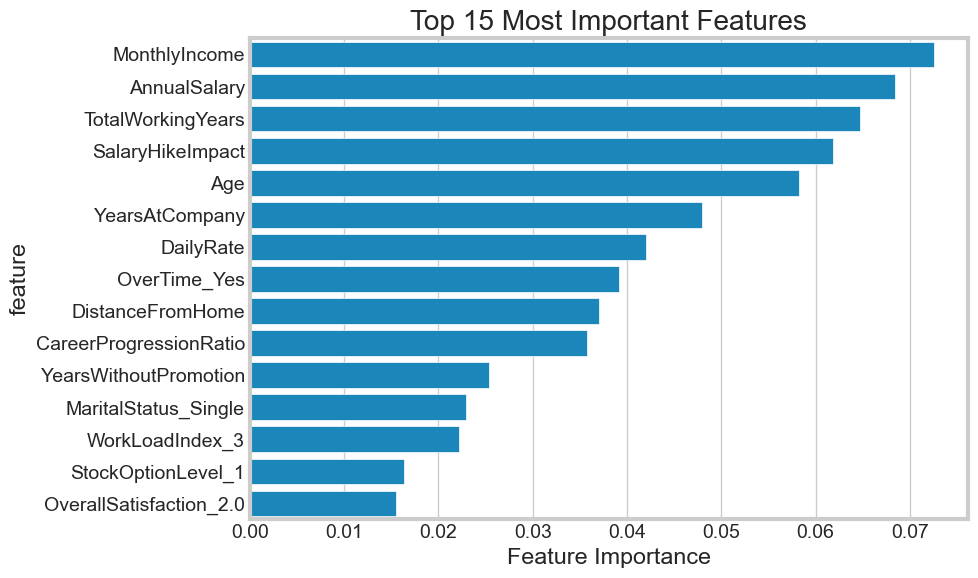

In [31]:
# Making predictions with probability scores
y_train_probs = rf_model.predict_proba(X_train)
y_test_probs = rf_model.predict_proba(X_test)

# Finding best threshold using training set
best_thresh = find_best_threshold(y_train, y_train_probs)

# Evaluating model using optimized threshold
evaluate_model(y_train, y_train_probs, "Training", threshold=best_thresh)
evaluate_model(y_test, y_test_probs, "Testing", threshold=best_thresh)

# Plotting feature importance
feature_importance = plot_feature_importance(rf_model, X)

Some of the Insights from the Model Evaluation:
1. **Improved Detection of Attrition** → Adjusting the threshold helps catch more employees likely to leave.  
2. **Strong Model Performance in Training** → The model learns well from past data, showing high accuracy.  
3. **Real-World Predictions Need Refinement** → While the model performs well, real-world predictions are slightly weaker.  
4. **Balancing Accuracy & Risk** → Lowering the threshold increases attrition detection but may also flag some employees incorrectly.  
5. **Potential for Optimization** → Additional data insights or refining the approach can further improve accuracy.  
6. **Actionable Insights for HR** → Helps in proactively identifying employees at risk of leaving, allowing for retention strategies.

Top features affecting attrition which could be identified include (exclusive of derived features): MonthlyIncome, TotalWorkingYears, SalaryHikeImpact, Age and YearsAtCompany.
